In [212]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [213]:
# Install necessary packages
!pip install -U nltk
!pip install rouge-score
!pip install transformers

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [214]:
!pip install --upgrade nltk

In [215]:
# Step 1: Import Libraries
import os
import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import nltk
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu, SmoothingFunction
from nltk.tokenize import word_tokenize
from nltk.translate.meteor_score import single_meteor_score
from rouge_score import rouge_scorer
from sklearn.model_selection import traian_test_split
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.notebook import trange, tqdm
from torch.distributions import Categorical

In [216]:
from transformers import (
    ViTModel,
    ViTFeatureExtractor,
    set_seed,
    DistilBertTokenizer,
    DistilBertModel
)

In [217]:
import torchvision
import torchvision.transforms as transforms

In [218]:
# Configure CUDA for mixed-precision training
torch.backends.cuda.matmul.allow_tf32 = True

In [219]:
# Download and unzip wordnet
import subprocess

nltk.download('wordnet', download_dir='/kaggle/working/')
command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
subprocess.run(command.split())
nltk.data.path.append('/kaggle/working/')

# Now you can import the NLTK resources as usual
from nltk.corpus import wordnet

nltk.download('punkt_tab')

Archive:  /kaggle/working/corpora/wordnet.zip


[nltk_data] Downloading package wordnet to /kaggle/working/...
[nltk_data]   Package wordnet is already up-to-date!
replace /kaggle/working/corpora/wordnet/lexnames? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL
(EOF or read error, treating as "[N]one" ...)
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [220]:
# Test WordNet
synonyms = wordnet.synsets('cat')
print(synonyms)

[Synset('cat.n.01'), Synset('guy.n.01'), Synset('cat.n.03'), Synset('kat.n.01'), Synset('cat-o'-nine-tails.n.01'), Synset('caterpillar.n.02'), Synset('big_cat.n.01'), Synset('computerized_tomography.n.01'), Synset('cat.v.01'), Synset('vomit.v.01')]


In [221]:
# Step 2: Load Dataset
work_directory = "/kaggle/input/deep-learning-ic-dataset/"
data_path = os.path.join(work_directory, "captions.csv")
data = pd.read_csv(data_path)

In [222]:
def preprocess_text(text):
    """
    Preprocesses the input text by lowercasing and tokenizing.

    Args:
        text (str): The input string.

    Returns:
        tuple: A tuple containing the list of tokens and the reconstructed string.
    """
    tokens = word_tokenize(text.lower())
    reconstructed_text = ' '.join(tokens)
    return tokens, reconstructed_text

In [223]:
# Create temporary directory
temp_directory = Path('../temp')
temp_directory.mkdir(exist_ok=True)

# Update file paths
data['filepath'] = data['filepath'].apply(lambda x: os.path.join(work_directory, x))

In [224]:
# Split into train and validation sets
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

In [225]:
# Save the split datasets (optional)
train_csv_path = os.path.join(temp_directory, "train_captions.csv")
val_csv_path = os.path.join(temp_directory, "val_captions.csv")

In [226]:
train_data.to_csv(train_csv_path, index=False)
val_data.to_csv(val_csv_path, index=False)

In [227]:
# Step 3: Define Custom Dataset
class CustomImageCaptionDataset(Dataset):
    def __init__(self, data_frame, tokenizer, max_length=50, transform=None):
        self.data = data_frame.reset_index(drop=True)
        self.transform = transform
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get file path and caption
        image_info = self.data.iloc[idx]
        image_path = image_info['filepath']
        caption = image_info['caption']

        # Load and transform the image
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        # Tokenize the caption
        tokens = self.tokenizer(
            caption,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        input_ids = tokens.input_ids.squeeze()  # (max_length)
        attention_mask = tokens.attention_mask.squeeze()  # (max_length)

        return image, input_ids, attention_mask

In [228]:
# Step 4: Define Image Transforms
image_size = 224  # Increased image size for better pre-trained model compatibility

train_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Values for ViT
                         std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.5)
])

val_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [229]:
# Step 5: Initialize Tokenizer and Feature Extractor
from transformers import DistilBertTokenizer, ViTFeatureExtractor

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")

# Add pad token if not present
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})

print(f"Tokenizer PAD Token: {tokenizer.pad_token}, PAD Token ID: {tokenizer.pad_token_id}")
print(f"Tokenizer BOS Token: {tokenizer.cls_token}, BOS Token ID: {tokenizer.cls_token_id}")
print(f"Tokenizer EOS Token: {tokenizer.sep_token}, EOS Token ID: {tokenizer.sep_token_id}")


Tokenizer PAD Token: [PAD], PAD Token ID: 0
Tokenizer BOS Token: [CLS], BOS Token ID: 101
Tokenizer EOS Token: [SEP], EOS Token ID: 102


/opt/conda/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [230]:
# Step 6: Create Datasets and DataLoaders
batch_size = 64  # Reduced batch size for computational efficiency
max_length = 50  # Maximum caption length

train_dataset = CustomImageCaptionDataset(
    data_frame=train_data,
    tokenizer=tokenizer,
    max_length=max_length,
    transform=train_transform
)

val_dataset = CustomImageCaptionDataset(
    data_frame=val_data,
    tokenizer=tokenizer,
    max_length=max_length,
    transform=val_transform
)

data_loader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
data_loader_val = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


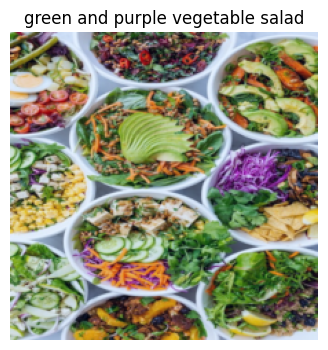

In [231]:
# Visualize an example
dataiter = next(iter(data_loader_val))
test_images, test_input_ids, test_attention_masks = dataiter

plt.figure(figsize=(4, 4))
out = torchvision.utils.make_grid(test_images[0:1], normalize=True)
plt.imshow(out.cpu().numpy().transpose((1, 2, 0)))
caption = tokenizer.decode(test_input_ids[0], skip_special_tokens=True)
plt.title(caption)
plt.axis('off')
plt.show()


In [232]:
class ViT_LSTM_CaptioningModel(nn.Module):
    def __init__(self, encoder, embedding_dim, hidden_dim, vocab_size, pad_token_id, num_layers=1, dropout=0.5):
        super(ViT_LSTM_CaptioningModel, self).__init__()
        self.encoder = encoder  # ViT encoder

        # DistilBERT Embedding
        self.distilbert = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.embedding = self.distilbert.embeddings.word_embeddings  # (vocab_size, embedding_dim)

        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        self.fc = nn.Linear(hidden_dim, vocab_size)

        self.token_drop = TokenDrop(prob=0.2, pad_token_id=pad_token_id, eos_token_id=tokenizer.sep_token_id)

        # Linear layers to map image features to LSTM hidden and cell states
        self.hidden_init = nn.Linear(encoder.config.hidden_size, hidden_dim)
        self.cell_init = nn.Linear(encoder.config.hidden_size, hidden_dim)

    def forward(self, images, input_ids, attention_mask, hidden=None):
        # Encode images
        encoder_outputs = self.encoder(images).last_hidden_state  # (batch_size, seq_length, encoder_dim)

        # Extract image features (e.g., using the [CLS] token)
        img_features = encoder_outputs[:, 0, :]  # (batch_size, encoder_dim)

        # Initialize hidden and cell states from image features
        if hidden is None:
            h_0 = self.hidden_init(img_features).unsqueeze(0)  # (num_layers, batch, hidden_dim)
            c_0 = self.cell_init(img_features).unsqueeze(0)    # (num_layers, batch, hidden_dim)
        else:
            h_0, c_0 = hidden

        # Apply token drop
        input_ids = self.token_drop(input_ids)

        # Get embeddings
        embeddings = self.embedding(input_ids)  # (batch_size, seq_length, embedding_dim)

        # Pass embeddings through LSTM
        outputs, hidden = self.lstm(embeddings, (h_0, c_0))  # (batch_size, seq_length, hidden_dim)

        # Predict next tokens
        logits = self.fc(outputs)  # (batch_size, seq_length, vocab_size)

        return logits, hidden

    def generate_caption(self, images, max_length=50, device='cuda'):
        self.eval()

        # Encode images
        with torch.no_grad():
            encoder_outputs = self.encoder(images).last_hidden_state  # (batch_size, seq_length, encoder_dim)
            img_features = encoder_outputs[:, 0, :]  # (batch_size, encoder_dim)
            h_0 = self.hidden_init(img_features).unsqueeze(0)  # (num_layers, batch, hidden_dim)
            c_0 = self.cell_init(img_features).unsqueeze(0)    # (num_layers, batch, hidden_dim)

        # Initialize generated_ids with the start token
        generated_ids = torch.zeros((images.size(0), 1), dtype=torch.long).fill_(tokenizer.cls_token_id).to(device)

        hidden = (h_0, c_0)

        for _ in range(max_length):
            # Embed the last generated token
            embeddings = self.embedding(generated_ids)  # (batch_size, current_length, embedding_dim)

            # Pass through LSTM
            outputs, hidden = self.lstm(embeddings, hidden)  # (batch_size, current_length, hidden_dim)

            # Get logits for the last time step
            logits = self.fc(outputs[:, -1, :])  # (batch_size, vocab_size)

            # Predict the next token
            predicted = logits.argmax(dim=-1).unsqueeze(1)  # (batch_size, 1)

            # Append predicted token to generated_ids
            generated_ids = torch.cat((generated_ids, predicted), dim=1)  # (batch_size, current_length +1)

            # Check if all sequences have generated EOS token
            if (predicted == tokenizer.sep_token_id).all():
                break

        return generated_ids


In [233]:
# Step 9: Initialize the Model
# Load ViT encoder
vit_encoder = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

# Freeze ViT parameters if desired
# for param in vit_encoder.parameters():
#     param.requires_grad = False

In [234]:
# Define model parameters
embedding_dim = vit_encoder.config.hidden_size  # Typically 768 for ViT
hidden_dim = 512
vocab_size = len(tokenizer)
pad_token_id = tokenizer.pad_token_id

In [235]:
# Step 7: Define TokenDrop Class
class TokenDrop(nn.Module):
    """Randomly replace tokens with the pad token during training.

    Args:
        prob (float): probability of replacing a token
        pad_token_id (int): index for the padding token
        eos_token_id (int): index for the end-of-sentence token
    """

    def __init__(self, prob=0.2, pad_token_id=0, eos_token_id=2):
        super(TokenDrop, self).__init__()
        self.prob = prob
        self.pad_token_id = pad_token_id
        self.eos_token_id = eos_token_id

    def forward(self, input_ids):
        if not self.training:
            return input_ids

        # Generate mask with probability 'prob'
        mask = torch.bernoulli(torch.full(input_ids.shape, self.prob)).to(input_ids.device)
        mask = mask.bool()

        # Do not replace special tokens
        mask = mask & (input_ids != self.eos_token_id) & (input_ids != self.pad_token_id)

        # Replace selected tokens with pad_token_id
        input_ids[mask] = self.pad_token_id

        return input_ids

In [236]:
# Initialize the model
model = ViT_LSTM_CaptioningModel(
    encoder=vit_encoder,
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    vocab_size=vocab_size,
    pad_token_id=pad_token_id,
    num_layers=1,
    dropout=0.2
)

In [237]:
# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ViT_LSTM_CaptioningModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in

In [238]:
# Resize tokenizer embeddings if necessary
model.distilbert.resize_token_embeddings(len(tokenizer))

print(f"Number of Model Parameters: {sum(p.numel() for p in model.parameters())} (~{sum(p.numel() for p in model.parameters())/1e6:.2f} Million)")

Number of Model Parameters: 171822906 (~171.82 Million)


In [239]:
# Step 10: Initialize the Optimizer and Loss Function
learning_rate = 1e-4  # Adjusted learning rate

optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss(ignore_index=pad_token_id)

In [240]:
# Initialize the training loss logger
training_loss_logger = []
eval_loss_logger = []
eval_bleu_logger = []
eval_meteor_logger = []
eval_rouge_logger = []

In [241]:
# Step 11: Define EarlyStopping Class (Retained)
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0.0, path='best_model_lstm.pt'):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.path = path

    def __call__(self, current_loss, model):
        if self.best_loss is None:
            self.best_loss = current_loss
            self.save_checkpoint(model)
        elif current_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = current_loss
            self.save_checkpoint(model)
            self.counter = 0

    def save_checkpoint(self, model):
        """Saves model when validation loss decreases."""
        torch.save(model.state_dict(), self.path)
        if self.verbose:
            print(f'Validation loss decreased. Saving model to {self.path}')

In [242]:
# Initialize Early Stopping
early_stopping = EarlyStopping(patience=3, verbose=True, path='best_model_lstm.pt')

# Initialize ROUGE scorer
rouge = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Initialize the smoothing function
smoothing_fn = SmoothingFunction().method1

# Step 12: Training Loop
nepochs = 10

In [243]:
# # Training and Evaluation Loop
# for epoch in trange(nepochs, desc="Epoch"):
#     # Training Phase
#     model.train()
#     epoch_train_loss = 0.0
#     num_train_batches = 0

#     for images, input_ids, attention_masks in tqdm(data_loader_train, desc="Training", leave=False):
#         images = images.to(device)
#         input_ids = input_ids.to(device)
#         attention_masks = attention_masks.to(device)

#         optimizer.zero_grad()

#         # Forward pass
#         logits, hidden = model(images, input_ids, attention_masks)

#         # Shift logits and labels for next-token prediction
#         # Exclude the first token for input and the last token for labels
#         logits = logits[:, :-1, :].reshape(-1, vocab_size)
#         labels = input_ids[:, 1:].reshape(-1)

#         # Compute loss
#         loss = loss_fn(logits, labels)

#         # Backward pass and optimization
#         loss.backward()

#         # Gradient Clipping
#         torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

#         optimizer.step()

#         epoch_train_loss += loss.item()
#         num_train_batches += 1

#     # Calculate Average Training Loss
#     avg_train_loss = epoch_train_loss / num_train_batches
#     training_loss_logger.append(avg_train_loss)
#     print(f"Epoch {epoch + 1}/{nepochs} - Avg Training Loss: {avg_train_loss:.4f}")

#     # Evaluation Phase
#     model.eval()
#     epoch_eval_loss = 0.0
#     num_eval_batches = 0
#     bleu_scores = []
#     meteor_scores = []
#     rouge1_scores = []
#     rouge2_scores = []
#     rougel_scores = []

#     with torch.no_grad():
#         for images, input_ids, attention_masks in tqdm(data_loader_val, desc="Evaluating", leave=False):
#             images = images.to(device)
#             input_ids = input_ids.to(device)
#             attention_masks = attention_masks.to(device)

#             # Forward pass
#             logits, hidden = model(images, input_ids, attention_masks)

#             # Shift logits and labels for next-token prediction
#             logits = logits[:, :-1, :].reshape(-1, vocab_size)
#             labels = input_ids[:, 1:].reshape(-1)

#             # Compute loss
#             loss = loss_fn(logits, labels)

#             epoch_eval_loss += loss.item()
#             num_eval_batches += 1

#             # Generate predictions
#             generated_ids = model.generate_caption(
#                 images,
#                 max_length=max_length,
#                 device=device
#             )

#             # Decode predictions and references
#             generated_captions = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
#             references = [tokenizer.decode(ids, skip_special_tokens=True) for ids in input_ids]

#             for gen, ref in zip(generated_captions, references):
#                 # Preprocess reference and hypothesis
#                 reference_tokens, ref_str = preprocess_text(ref)
#                 hypothesis_tokens, gen_str = preprocess_text(gen)

#                 # BLEU Score
#                 bleu = sentence_bleu(
#                     [reference_tokens], 
#                     hypothesis_tokens, 
#                     smoothing_function=smoothing_fn
#                 )
#                 bleu_scores.append(bleu)

#                 # Meteor Score
#                 meteor = single_meteor_score(ref_str, gen_str)
#                 meteor_scores.append(meteor)

#                 # ROUGE Scores
#                 scores = rouge.score(ref_str, gen_str)
#                 rouge1_scores.append(scores['rouge1'].fmeasure)
#                 rouge2_scores.append(scores['rouge2'].fmeasure)
#                 rougel_scores.append(scores['rougeL'].fmeasure)

#     # Calculate Average Metrics
#     avg_eval_loss = epoch_eval_loss / num_eval_batches
#     avg_bleu = np.mean(bleu_scores) if bleu_scores else 0.0
#     avg_meteor = np.mean(meteor_scores) if meteor_scores else 0.0
#     avg_rouge1 = np.mean(rouge1_scores) if rouge1_scores else 0.0
#     avg_rouge2 = np.mean(rouge2_scores) if rouge2_scores else 0.0
#     avg_rougeL = np.mean(rougel_scores) if rougel_scores else 0.0

#     # Log Metrics
#     eval_loss_logger.append(avg_eval_loss)
#     eval_bleu_logger.append(avg_bleu)
#     eval_meteor_logger.append(avg_meteor)
#     eval_rouge_logger.append({
#         'rouge1': avg_rouge1,
#         'rouge2': avg_rouge2,
#         'rougeL': avg_rougeL
#     })

#     # Print Metrics
#     print(f"Epoch {epoch + 1}/{nepochs} - Avg Eval Loss: {avg_eval_loss:.4f} - "
#           f"Avg BLEU: {avg_bleu:.4f} - Avg Meteor: {avg_meteor:.4f} - "
#           f"Avg Rouge1: {avg_rouge1:.4f}, Rouge2: {avg_rouge2:.4f}, RougeL: {avg_rougeL:.4f}")

#     # Early Stopping Check
#     early_stopping(avg_eval_loss, model)
#     if early_stopping.early_stop:
#         print("Early stopping triggered. Restoring the best model.")
#         model.load_state_dict(torch.load('best_model_lstm.pt'))
#         break


In [244]:
# Training and Evaluation Loop
for epoch in trange(nepochs, desc="Epoch"):
    # Training Phase
    model.train()
    epoch_train_loss = 0.0
    num_train_batches = 0

    for images, input_ids, attention_masks in tqdm(data_loader_train, desc="Training", leave=False):
        images = images.to(device)
        input_ids = input_ids.to(device)
        attention_masks = attention_masks.to(device)

        optimizer.zero_grad()

        # Forward pass
        logits, hidden = model(images, input_ids, attention_masks)

        # Shift logits and labels for next-token prediction
        # Exclude the first token for input and the last token for labels
        logits = logits[:, :-1, :].reshape(-1, vocab_size)
        labels = input_ids[:, 1:].reshape(-1)

        # Compute loss
        loss = loss_fn(logits, labels)

        # Backward pass and optimization
        loss.backward()

        # Gradient Clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        epoch_train_loss += loss.item()
        num_train_batches += 1

    # Calculate Average Training Loss
    avg_train_loss = epoch_train_loss / num_train_batches
    training_loss_logger.append(avg_train_loss)
    print(f"Epoch {epoch + 1}/{nepochs} - Avg Training Loss: {avg_train_loss:.4f}")

    # Evaluation Phase
    model.eval()
    epoch_eval_loss = 0.0
    num_eval_batches = 0
    bleu_scores = []
    meteor_scores = []
    rouge1_scores = []
    rouge2_scores = []
    rougel_scores = []

    with torch.no_grad():
        for images, input_ids, attention_masks in tqdm(data_loader_val, desc="Evaluating", leave=False):
            images = images.to(device)
            input_ids = input_ids.to(device)
            attention_masks = attention_masks.to(device)

            # Forward pass
            logits, hidden = model(images, input_ids, attention_masks)

            # Shift logits and labels for next-token prediction
            logits = logits[:, :-1, :].reshape(-1, vocab_size)
            labels = input_ids[:, 1:].reshape(-1)

            # Compute loss
            loss = loss_fn(logits, labels)

            epoch_eval_loss += loss.item()
            num_eval_batches += 1

            # Generate predictions
            generated_ids = model.generate_caption(
                images,
                max_length=max_length,
                device=device
            )

            # Decode predictions and references
            generated_captions = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
            references = [tokenizer.decode(ids, skip_special_tokens=True) for ids in input_ids]

            for gen, ref in zip(generated_captions, references):
                # Preprocess reference and hypothesis
                reference_tokens, ref_str = preprocess_text(ref)
                hypothesis_tokens, gen_str = preprocess_text(gen)

                # BLEU Score
                bleu = sentence_bleu(
                    [reference_tokens], 
                    hypothesis_tokens, 
                    smoothing_function=smoothing_fn
                )
                bleu_scores.append(bleu)

                # Meteor Score - Pass token lists instead of strings
                meteor = single_meteor_score(reference_tokens, hypothesis_tokens)
                meteor_scores.append(meteor)

                # ROUGE Scores
                scores = rouge.score(ref_str, gen_str)  # ROUGE expects strings
                rouge1_scores.append(scores['rouge1'].fmeasure)
                rouge2_scores.append(scores['rouge2'].fmeasure)
                rougel_scores.append(scores['rougeL'].fmeasure)

    # Calculate Average Metrics
    avg_eval_loss = epoch_eval_loss / num_eval_batches
    avg_bleu = np.mean(bleu_scores) if bleu_scores else 0.0
    avg_meteor = np.mean(meteor_scores) if meteor_scores else 0.0
    avg_rouge1 = np.mean(rouge1_scores) if rouge1_scores else 0.0
    avg_rouge2 = np.mean(rouge2_scores) if rouge2_scores else 0.0
    avg_rougeL = np.mean(rougel_scores) if rougel_scores else 0.0

    # Log Metrics
    eval_loss_logger.append(avg_eval_loss)
    eval_bleu_logger.append(avg_bleu)
    eval_meteor_logger.append(avg_meteor)
    eval_rouge_logger.append({
        'rouge1': avg_rouge1,
        'rouge2': avg_rouge2,
        'rougeL': avg_rougeL
    })

    # Print Metrics
    print(f"Epoch {epoch + 1}/{nepochs} - Avg Eval Loss: {avg_eval_loss:.4f} - "
          f"Avg BLEU: {avg_bleu:.4f} - Avg Meteor: {avg_meteor:.4f} - "
          f"Avg Rouge1: {avg_rouge1:.4f}, Rouge2: {avg_rouge2:.4f}, RougeL: {avg_rougeL:.4f}")

    # Early Stopping Check
    early_stopping(avg_eval_loss, model)
    if early_stopping.early_stop:
        print("Early stopping triggered. Restoring the best model.")
        model.load_state_dict(torch.load('best_model_lstm.pt'))
        break

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/200 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 38.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 6.12 MiB is free. Process 4383 has 14.73 GiB memory in use. Of the allocated memory 14.26 GiB is allocated by PyTorch, and 346.06 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
print(len(training_loss_logger), len(eval_loss_logger), len(eval_bleu_logger))

In [ ]:
# Define the range and step size for y-axis ticks for both training and eval losses
y_min, y_max = min(min(training_loss_logger), min(eval_loss_logger)), max(max(training_loss_logger), max(eval_loss_logger))
step = (y_max - y_min) / 10  # Set 10 evenly spaced ticks (adjust if needed)
y_ticks = np.arange(y_min, y_max + step, step)

# Create the plot
_ = plt.figure(figsize=(10, 5))

# Plot training loss
_ = plt.plot(training_loss_logger, label="Training Loss", color='tab:blue')

# Plot evaluation loss
_ = plt.plot(eval_loss_logger, label="Evaluation Loss", color='tab:orange')

# Apply custom y-ticks
_ = plt.yticks(y_ticks)

# Add labels, title, legend, and grid
_ = plt.title("Training and Evaluation Loss")
_ = plt.xlabel("Epochs")
_ = plt.ylabel("Loss")
_ = plt.legend()
_ = plt.grid(True)

# Show the plot
plt.show()

In [ ]:
# Define the range and step size for y-axis ticks for both training and eval losses
y_min, y_max = min(min(eval_bleu_logger), min(eval_meteor_logger)), max(max(eval_bleu_logger), max(eval_meteor_logger))
step = (y_max - y_min) / 10  # Set 10 evenly spaced ticks (adjust if needed)
y_ticks = np.arange(y_min, y_max + step, step)

# Create the plot
_ = plt.figure(figsize=(10, 5))

# Plot training loss
_ = plt.plot(eval_bleu_logger, label="Bleu", color='tab:blue')

# Plot evaluation loss
_ = plt.plot(eval_meteor_logger, label="Meteor", color='tab:orange')

# Apply custom y-ticks
_ = plt.yticks(y_ticks)

# Add labels, title, legend, and grid
_ = plt.title("Bleu and Meteor Value")
_ = plt.xlabel("Epochs")
_ = plt.ylabel("Loss")
_ = plt.legend()
_ = plt.grid(True)

# Show the plot
plt.show()

In [ ]:
# Extract ROUGE scores
rouge1_scores = [entry['rouge1'] for entry in eval_rouge_logger]
rouge2_scores = [entry['rouge2'] for entry in eval_rouge_logger]
rougeL_scores = [entry['rougeL'] for entry in eval_rouge_logger]

# Define the range and step size for y-axis ticks for ROUGE scores
all_rouge_scores = rouge1_scores + rouge2_scores + rougeL_scores
y_min, y_max = min(all_rouge_scores), max(all_rouge_scores)
step = (y_max - y_min) / 10  # Set 10 evenly spaced ticks
y_ticks = np.arange(y_min, y_max + step, step)

# Create the plot
_ = plt.figure(figsize=(10, 5))

# Plot ROUGE scores
_ = plt.plot(rouge1_scores, label="ROUGE-1", color='tab:green')
_ = plt.plot(rouge2_scores, label="ROUGE-2", color='tab:red')
_ = plt.plot(rougeL_scores, label="ROUGE-L", color='tab:purple')

# Apply custom y-ticks
_ = plt.yticks(y_ticks)

# Add labels, title, legend, and grid
_ = plt.title("ROUGE Scores Across Epochs")
_ = plt.xlabel("Epochs")
_ = plt.ylabel("ROUGE Score")
_ = plt.legend()
_ = plt.grid(True)

# Show the plot
plt.show()

In [ ]:
# Extract ROUGE scores
rouge1_scores = [entry['rouge1'] for entry in eval_rouge_logger]
rouge2_scores = [entry['rouge2'] for entry in eval_rouge_logger]
rougeL_scores = [entry['rougeL'] for entry in eval_rouge_logger]

# Define the range and step size for y-axis ticks for all metrics
all_metrics = eval_bleu_logger + eval_meteor_logger + rouge1_scores + rouge2_scores + rougeL_scores
y_min, y_max = min(all_metrics), max(all_metrics)
step = (y_max - y_min) / 10  # Set 10 evenly spaced ticks
y_ticks = np.arange(y_min, y_max + step, step)

# Create the plot
_ = plt.figure(figsize=(12, 6))

# Plot BLEU and Meteor scores
_ = plt.plot(eval_bleu_logger, label="BLEU", color='tab:blue')
_ = plt.plot(eval_meteor_logger, label="Meteor", color='tab:orange')

# Plot ROUGE scores
_ = plt.plot(rouge1_scores, label="ROUGE-1", color='tab:green')
_ = plt.plot(rouge2_scores, label="ROUGE-2", color='tab:red')
_ = plt.plot(rougeL_scores, label="ROUGE-L", color='tab:purple')

# Apply custom y-ticks
_ = plt.yticks(y_ticks)

# Add labels, title, legend, and grid
_ = plt.title("Evaluation Metrics Across Epochs")
_ = plt.xlabel("Epochs")
_ = plt.ylabel("Metric Value")
_ = plt.legend()
_ = plt.grid(True)

# Show the plot
plt.show()

## Save Model

In [80]:
# Step 13: Save the Final Model
torch.save(model.state_dict(), 'final_model_lstm.pt')
print("Model saved as 'final_model_lstm.pt'")

Model saved as 'final_model_lstm.pt'


In [39]:
model

ViT_LSTM_CaptioningModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in

In [89]:
# Save model and optimizer state dicts
torch.save({
    'epoch': nepochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': training_loss_logger[-1],
}, "checkpoint.pth")

In [90]:
from IPython.display import FileLink
FileLink(r'checkpoint.pth')

/kaggle/working/checkpoint.pth

## Inference Model

In [209]:
# Inference Example
# Select a sample from the validation set
test_image, actual_input_ids, actual_attention_mask = val_dataset[10]
test_image = test_image.unsqueeze(0).to(device)  # Add batch dimension

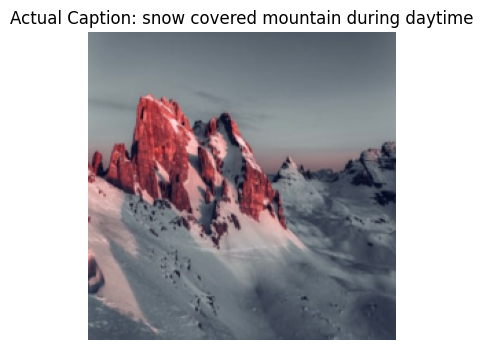

In [210]:
# Visualize the image
plt.figure(figsize=(4, 4))
out = torchvision.utils.make_grid(test_image.cpu(), normalize=True)
plt.imshow(out.permute(1, 2, 0).numpy())
caption = tokenizer.decode(actual_input_ids, skip_special_tokens=True)
plt.title("Actual Caption: " + caption)
plt.axis('off')
plt.show()

In [211]:
# Generate prediction
model.eval()
with torch.no_grad():
    generated_ids = model.generate_caption(
        test_image,
        max_length=50,
        device=device
    )
    pred_caption = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

# Display the generated caption
print("Generated Caption:", pred_caption)

RuntimeError: input.size(-1) must be equal to input_size. Expected 512, got 768

## Inference from Load Model

In [202]:
# Step 1: Define Image Preprocessing
image_size = 224  # For ViT compatibility
val_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Standard for pre-trained models
                         std=[0.229, 0.224, 0.225])
])

# Step 2: Define the Model Initialization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

embedding_dim = 768  # Adjust as per your embedding dimension
hidden_dim = 512  # Hidden size compatible with ViT encoder
vocab_size = tokenizer.vocab_size  # Vocabulary size from the tokenizer
pad_token_id = tokenizer.pad_token_id  # Padding token ID from the tokenizer

In [203]:
# Initialize the ViT-LSTM model
model_loaded = ViT_LSTM_CaptioningModel(
    encoder=vit_encoder,  # Pre-trained ViT encoder
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    vocab_size=vocab_size,
    pad_token_id=pad_token_id,
    num_layers=1,
    dropout=0.2
).to(device)

In [204]:
# Step 3: Load the Pre-trained Model Weights
model_loaded.load_state_dict(torch.load("final_model_lstm.pt", map_location=device))
model_loaded.eval()

/tmp/ipykernel_23/4159442809.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_loaded.load_state_dict(torch.load("final_model_lstm.pt", map_location=device))


ViT_LSTM_CaptioningModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in

In [205]:
# Step 4: Define a Function for Captioning an Image
def generate_caption(image_path, max_length=30):
    """
    Generate a caption for an input image using the pre-trained ViT-LSTM model.
    Args:
        image_path (str): Path to the image file.
        max_length (int): Maximum length of the generated caption.
    Returns:
        str: Generated caption.
    """
    # Preprocess the image
    image = Image.open(image_path).convert("RGB")
    image_tensor = val_transform(image).unsqueeze(0).to(device)  # Add batch dimension

    # Generate caption
    with torch.no_grad():
        caption_ids = model.generate_caption(
            image_tensor, max_length=max_length, device=device
        )
    return tokenizer.decode(caption_ids[0], skip_special_tokens=True)


In [206]:
# Step 5: Inference Example
image_path = data['filepath'][0]  # Replace with the path to your image
assert os.path.exists(image_path), f"Image not found at {image_path}"

In [207]:
caption = generate_caption(image_path)
print("Generated Caption:", caption)

RuntimeError: input.size(-1) must be equal to input_size. Expected 512, got 768